In [ ]:
%reset -f

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [ ]:
df= pd.read_csv('/content/sample_data/2019-Dec.csv')

In [ ]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-12-01 00:00:00 UTC,remove_from_cart,5712790,1487580005268456287,NaN,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc
1,2019-12-01 00:00:00 UTC,view,5764655,1487580005411062629,NaN,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18
2,2019-12-01 00:00:02 UTC,cart,4958,1487580009471148064,NaN,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554
3,2019-12-01 00:00:05 UTC,view,5848413,1487580007675986893,NaN,freedecor,0.79,348405118,722ffea5-73c0-4924-8e8f-371ff8031af4
4,2019-12-01 00:00:07 UTC,view,5824148,1487580005511725929,NaN,NaN,5.56,576005683,28172809-7e4a-45ce-bab0-5efa90117cd5


session id(유저가 플랫폼에 진입한 이후, 특정 기간 동안 임시적으로 부여된 id)

-> 해당 id는 특정 기간 이후로 활동이 없다면, 다시 진입하는 순간 새로운 session id를 부여받음.

따라서, 동일한 session id로 중복된 event가 발생한다면 한번의 id만 카운트 (session id에 대한 고유값만 측정)

In [ ]:
df['event_type'].unique()

array(['remove_from_cart', 'view', 'cart', 'purchase'], dtype=object)

유저들의 경로:
- view - cart - purchase
- view - cart - remove_from_cart
- view - purchase

In [ ]:
df['event_time'] = pd.to_datetime(df['event_time'])

### **데이터 전처리**

---



1. 중복값 처리

In [ ]:
df = df.drop_duplicates()

2. 결측값 처리

In [ ]:
df.isna().sum()

,0
event_time,0
event_type,0
product_id,0
category_id,0
category_code,3242057
brand,1405835
price,0
user_id,0
user_session,707


In [ ]:
#분석에 의미없는 카테고리 코드 제거
df = df.drop('category_code', axis=1)

#총 2541810 데이터 중 1072879(brand 결측치) 제거해도 1,468,931개의 데이터를 확보할 수 있기 때문에 단순 제거
df = df.dropna(subset = ['brand','price','user_id','user_session'])

df.isna().sum()

,0
event_time,0
event_type,0
product_id,0
category_id,0
brand,0
price,0
user_id,0
user_session,0


3. 이상치(Outliers) 처리

In [ ]:
df['event_time'].describe()

,event_time
count,1891487
mean,2019-12-14 14:46:47.211828992+00:00
min,2019-12-01 00:00:00+00:00
25%,2019-12-07 17:24:35.500000+00:00
50%,2019-12-14 04:55:29+00:00
75%,2019-12-21 08:51:01.500000+00:00
max,2019-12-30 15:27:58+00:00


- 2019-12-01부터 2019-12-31 한달 간의 데이터
- 날짜에 대한 이상치 없음

### **Funnel 분석**

---



하나의 세션마다 View Page, Cart, Purchase, Remove From Cart에 대한 고객들의 다양한 여정 중,

view - cart - purchase / view - cart - remove_from_cart / view - purchase 3가지 루트에 집중해서 분석

1. 전체 퍼널 분석

In [ ]:
# 이벤트 유형별 카운트
event_counts = df['event_type'].value_counts()

# 전환율 계산
view_count = event_counts.get('view', 0)
cart_count = event_counts.get('cart', 0)
remove_count = event_counts.get('remove_from_cart', 0)
purchase_count = event_counts.get('purchase', 0)

# 전환율 계산
view_to_cart_conversion = (cart_count / view_count) * 100 if view_count > 0 else 0
cart_to_purchase_conversion = (purchase_count / cart_count) * 100 if cart_count > 0 else 0
cart_to_remove_count_conversion = (remove_count / cart_count) * 100 if cart_count > 0 else 0
view_to_purchase = (purchase_count / view_count) * 100 if view_count > 0 else 0

# 결과 출력
print(f"조회(View) 수: {view_count}")
print(f"장바구니 추가(Cart) 수: {cart_count}")
print(f"장바구니 제거(Remove from Cart) 수: {remove_count}")
print(f"구매(Purchase) 수: {purchase_count}\n")

print(f"조회에서 장바구니 추가로의 전환율: {view_to_cart_conversion:.2f}%")
print(f"장바구니에서 구매로의 전환율: {cart_to_purchase_conversion:.2f}%\n")
print(f"장바구니에서 제거로의 전환율: {cart_to_remove_count_conversion:.2f}%\n")
print(f"조회에서 구매로의 전환율: {view_to_purchase:.2f}%")

조회(View) 수: 991272
장바구니 추가(Cart) 수: 507071
장바구니 제거(Remove from Cart) 수: 272859
구매(Purchase) 수: 120285

조회에서 장바구니 추가로의 전환율: 51.15%
장바구니에서 구매로의 전환율: 23.72%

장바구니에서 제거로의 전환율: 53.81%

조회에서 구매로의 전환율: 12.13%


- view - cart - purchase
> 조회에서 장바구니 추가로의 전환율: 50.91%
> 장바구니에서 구매로의 전환율: 23.63%

- view - cart - remove_from_cart
> 조회에서 장바구니 추가로의 전환율: 50.91%
> 장바구니에서 제거로의 전환율: 53.79%

- view - purchase
> 조회에서 구매로의 전환율: 12.03%

In [ ]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 데이터 준비
view_count = event_counts.get('view', 0)
cart_count = event_counts.get('cart', 0)
purchase_count = event_counts.get('purchase', 0)
remove_count = event_counts.get('remove_from_cart', 0)

# 전환율 계산
view_to_cart_conversion = (cart_count / view_count) * 100 if view_count > 0 else 0
cart_to_purchase_conversion = (purchase_count / cart_count) * 100 if cart_count > 0 else 0
cart_to_remove_conversion = (remove_count / cart_count) * 100 if cart_count > 0 else 0

# 퍼널 데이터 준비
funnel_data_1 = {
    '단계': ['조회(View)', '장바구니 추가(Cart)', '구매(Purchase)'],
    '수량': [view_count, cart_count, purchase_count],
    '전환율': [None, view_to_cart_conversion, cart_to_purchase_conversion]
}

funnel_data_2 = {
    '단계': ['조회(View)', '장바구니 추가(Cart)', '장바구니에서 제거(Remove From Cart)'],
    '수량': [view_count, cart_count, remove_count],
    '전환율': [None, view_to_cart_conversion, cart_to_remove_conversion]
}

# 데이터프레임 생성
funnel_df_1 = pd.DataFrame(funnel_data_1)
funnel_df_2 = pd.DataFrame(funnel_data_2)

# 서브플롯 생성
fig = make_subplots(rows=1, cols=2, subplot_titles=("View - Cart - Purchase", "View - Cart - Remove From Cart"))

# 첫 번째 퍼널 차트 추가
fig.add_trace(
    go.Funnel(y=funnel_df_1['단계'], x=funnel_df_1['수량'], textinfo="value+percent initial"),
    row=1, col=1
)

# 두 번째 퍼널 차트 추가
fig.add_trace(
    go.Funnel(y=funnel_df_2['단계'], x=funnel_df_2['수량'], textinfo="value+percent initial"),
    row=1, col=2
)

# 레이아웃 업데이트
fig.update_layout(title_text="전환율 분석", showlegend=False)

# 그래프 표시
fig.show()

- Cart에서 Purchase의 전환율이 23% / View page에서 Purchase까지의 전환율 12%임을 확인
> Cart에서 Purchase의 전환율을 증가시키는 것이 필요하다는 것을 알 수 있음

- Remove From Cart Funnel에서 볼 수 있듯이 구매보다 장바구니에서 제거되는 물건이 많다는 것을 확인 할 수 있음

2. 세션별 퍼널 분석

2.1 view - cart - purchase 과정을 거쳐온 session







<ipython-input-74-c0e55c1dc251>:32: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-74-c0e55c1dc251>:40: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




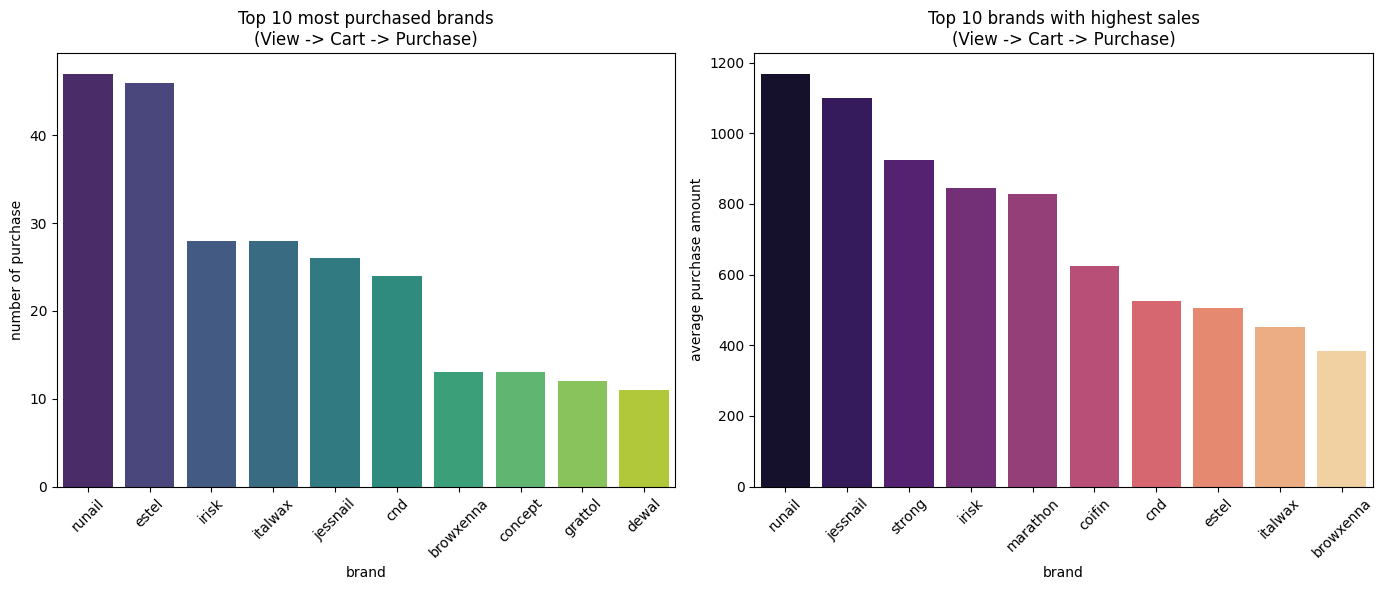

In [ ]:
# 세션별 이벤트 정렬
df.sort_values(by=['user_session', 'event_time'], inplace=True)
brand_analysis_data = []

# 세션별로 이벤트를 분석
for session_id, group in df.groupby('user_session'):
    events = group['event_type'].tolist()

    # view -> cart -> purchase 순서로 정확히 일치하는 세션만 분석
    if events == ['view', 'cart', 'purchase']:
        # 구매 이벤트 행 선택
        purchase_row = group[group['event_type'] == 'purchase'].iloc[0]
        brand_analysis_data.append({
            'brand': purchase_row['brand'],
            'price': purchase_row['price']
        })

brand_analysis_df = pd.DataFrame(brand_analysis_data)

# 구매가 많은 10개 브랜드 추출
brand_purchase_counts = brand_analysis_df['brand'].value_counts()
top_10_brands = brand_purchase_counts.head(10)

# 판매액이 높은 10개 브랜드 추출
total_sales_by_brand = brand_analysis_df.groupby('brand')['price'].sum()
top_10_sales_brands = total_sales_by_brand.nlargest(10)

plt.figure(figsize=(14, 6))

# 가장 많이 구매한 상위 10개 브랜드
plt.subplot(1, 2, 1)
sns.barplot(x=top_10_brands.index, y=top_10_brands.values, palette='viridis')
plt.title("Top 10 most purchased brands\n(View -> Cart -> Purchase)")
plt.xlabel("brand")
plt.ylabel("number of purchase")
plt.xticks(rotation=45)

# 판매액이 높은 10개 브랜드
plt.subplot(1, 2, 2)
sns.barplot(x=top_10_sales_brands.index, y=top_10_sales_brands.values, palette='magma')
plt.title("Top 10 brands with highest sales\n(View -> Cart -> Purchase)")
plt.xlabel("brand")
plt.ylabel("average purchase amount")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

-> view - cart - purchase 과정을 거쳐온 session 유저들은
- runail - estel - irisk - italwax - jessnail 순으로 구매를 많이 한 것을 확인
- runail - jessnail - strong - irisk - marathon 순으로 판매 금액이 높은 것을 확인

In [ ]:
# 전체 세션 수 계산
total_sessions = df['user_session'].nunique()

# 각 단계별 세션 수 계산
view_sessions = df[df['event_type'] == 'view']['user_session'].nunique()
cart_sessions = df[df['event_type'] == 'cart']['user_session'].nunique()
purchase_sessions = len(brand_analysis_data)

# Plotly Funnel Chart
fig = go.Figure(go.Funnel(
    y = ['Total Sessions', 'View', 'Cart', 'Purchase'],
    x = [total_sessions, view_sessions, cart_sessions, purchase_sessions],
    textinfo = "value+percent initial"
))

fig.update_layout(
    title='Conversion Funnel (View -> Cart -> Purchase)',
    height=500,
    width=700
)

fig.show()

- View에서 Cart로 넘어오는 과정에서 많은 이탈이 발생하는 것을 확인
- Purchase로 이어지는 conversion rate은 매우 저조함

2.2 view - cart - remove_from_cart 과정을 거쳐온 session

<ipython-input-76-257ab527c3da>:34: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-76-257ab527c3da>:41: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




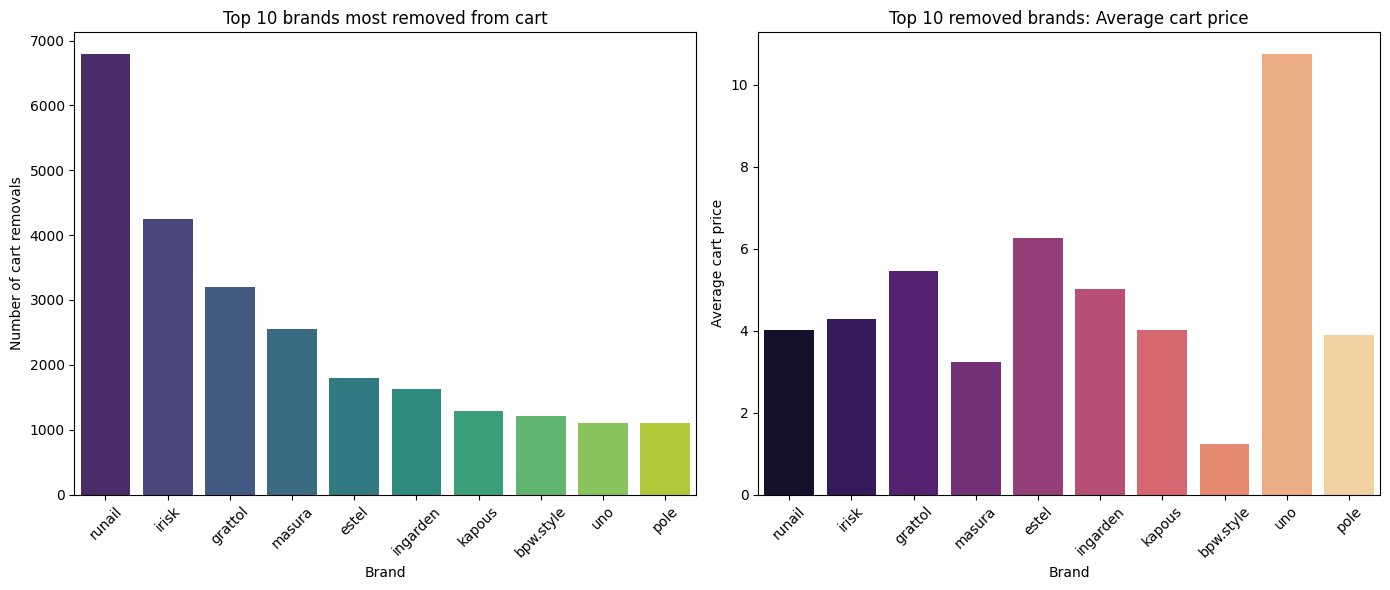

In [ ]:
# 세션별 이벤트 정렬
df.sort_values(by=['user_session', 'event_time'], inplace=True)
brand_analysis_data_remove = []

# 세션별로 이벤트를 분석
for session_id, group in df.groupby('user_session'):
    events = group['event_type'].tolist()

    # 'remove_from_cart'가 있는 세션만 분석
    if 'remove_from_cart' in events:
        # 마지막 'cart' 이벤트 행 선택
        cart_rows = group[group['event_type'] == 'cart']
        if not cart_rows.empty:
            last_cart_row = cart_rows.iloc[-1]
            brand_analysis_data_remove.append({
                'brand': last_cart_row['brand'],
                'price': last_cart_row['price']
            })

brand_analysis_df_remove = pd.DataFrame(brand_analysis_data_remove)

# 제거가 많은 10개 브랜드 추출
brand_remove_counts = brand_analysis_df_remove['brand'].value_counts()
top_10_brands_remove = brand_remove_counts.head(10)

# 제거된 상품의 브랜드별 평균 가격 계산
brand_avg_prices = brand_analysis_df_remove.groupby('brand')['price'].mean()
top_10_brands_remove_avg_prices = brand_avg_prices[top_10_brands_remove.index]

# 그래프 그리기
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=top_10_brands_remove.index, y=top_10_brands_remove.values, palette='viridis')
plt.title("Top 10 brands most removed from cart")
plt.xlabel("Brand")
plt.ylabel("Number of cart removals")
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(x=top_10_brands_remove_avg_prices.index, y=top_10_brands_remove_avg_prices.values, palette='magma')
plt.title("Top 10 removed brands: Average cart price")
plt.xlabel("Brand")
plt.ylabel("Average cart price")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

-> view - cart - remove_from_cart 과정을 거쳐온 session
- 장바구니 안에서 Runil - irisk - grattol - estel - masura 순으로 제거가 많이 일어난다는 것을 확인
- 장바구니에서 제거가 많이 되는 브랜드의 제품 평균 가격을 확인해본 결과, 대부분 $10 아래로 구매로 이어진 브랜드의 평균보다 현저히 낮은것을 확인

In [ ]:
# 전체 세션 수 계산
total_sessions = df['user_session'].nunique()

# 각 단계별 세션 수 계산
view_sessions = df[df['event_type'] == 'view']['user_session'].nunique()
cart_sessions = df[df['event_type'] == 'cart']['user_session'].nunique()
remove_sessions = df[df['event_type'] == 'remove_from_cart']['user_session'].nunique()

# Plotly Funnel Chart
fig = go.Figure(go.Funnel(
    y = ['Total Sessions', 'View', 'Cart', 'Remove from Cart'],
    x = [total_sessions, view_sessions, cart_sessions, remove_sessions],
    textinfo = "value+percent initial"
))

fig.update_layout(
    title='Conversion Funnel (Including Remove from Cart)',
    height=500,
    width=700
)

fig.show()

2.3 view - purchase 과정을 거쳐온 session

<ipython-input-78-57004970d073>:32: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-78-57004970d073>:40: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




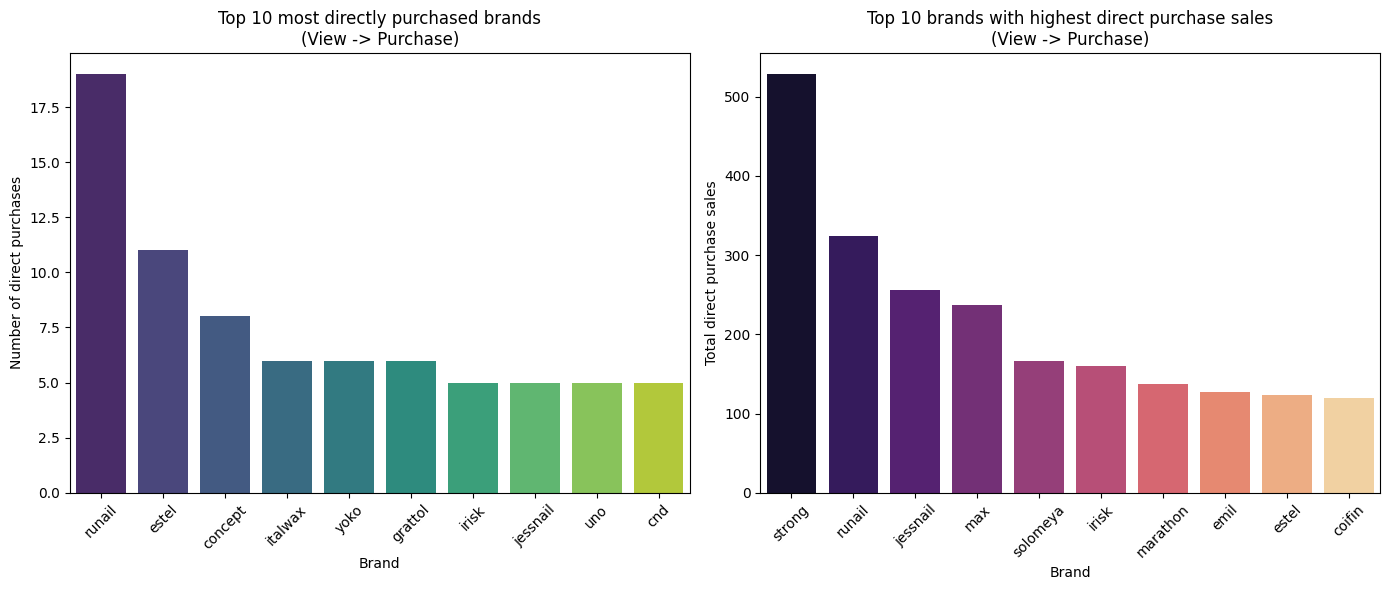

In [ ]:
# 세션별 이벤트 정렬
df.sort_values(by=['user_session', 'event_time'], inplace=True)
brand_analysis_data_direct = []

# 세션별로 이벤트를 분석
for session_id, group in df.groupby('user_session'):
    events = group['event_type'].tolist()

    # view -> purchase 순서로 정확히 일치하는 세션만 분석
    if events == ['view', 'purchase']:
        # 구매 이벤트 행 선택
        purchase_row = group[group['event_type'] == 'purchase'].iloc[0]
        brand_analysis_data_direct.append({
            'brand': purchase_row['brand'],
            'price': purchase_row['price']
        })

brand_analysis_df_direct = pd.DataFrame(brand_analysis_data_direct)

# 직접 구매가 많은 10개 브랜드 추출
brand_purchase_counts_direct = brand_analysis_df_direct['brand'].value_counts()
top_10_brands_direct = brand_purchase_counts_direct.head(10)

# 직접 구매 판매액이 높은 10개 브랜드 추출
total_sales_by_brand_direct = brand_analysis_df_direct.groupby('brand')['price'].sum()
top_10_sales_brands_direct = total_sales_by_brand_direct.nlargest(10)

plt.figure(figsize=(14, 6))

# 가장 많이 직접 구매한 상위 10개 브랜드
plt.subplot(1, 2, 1)
sns.barplot(x=top_10_brands_direct.index, y=top_10_brands_direct.values, palette='viridis')
plt.title("Top 10 most directly purchased brands\n(View -> Purchase)")
plt.xlabel("Brand")
plt.ylabel("Number of direct purchases")
plt.xticks(rotation=45)

# 직접 구매 판매액이 높은 10개 브랜드
plt.subplot(1, 2, 2)
sns.barplot(x=top_10_sales_brands_direct.index, y=top_10_sales_brands_direct.values, palette='magma')
plt.title("Top 10 brands with highest direct purchase sales\n(View -> Purchase)")
plt.xlabel("Brand")
plt.ylabel("Total direct purchase sales")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

-> view - purchase 과정을 거쳐온 session 유저들은
- runail - estel - concept - italwax - yoko 순으로 판매를 많이하는 것을 확인
- strong - runail - jessnail - max - solomeya 순으로 판매 금액이 높은 것을 확인

view page애서 purchase로 이어지는 session에 대한 전환율 확인

In [ ]:
# 데이터프레임 정렬
df.sort_values(by=['user_session', 'event_time'], inplace=True)

# view, cart, purchase 이벤트를 필터링
df['is_view'] = df['event_type'] == 'view'
df['is_cart'] = df['event_type'] == 'cart'
df['is_purchase'] = df['event_type'] == 'purchase'

# view 이벤트 다음에 cart, purchase가 있는지 확인
df['next_event_is_purchase'] = df['is_purchase'].shift(-1)
df['next_event_is_cart'] = df['is_cart'].shift(-1)

df['next_event_is_cart'].fillna(False, inplace=True)
df['next_event_is_purchase'].fillna(False, inplace=True)

# 조건을 만족하는 세션 찾기
valid_sessions = df[(df['is_view']) & (df['next_event_is_purchase']) & (~df['next_event_is_cart'])]['user_session'].unique()

VP_filtered_df = df[df['user_session'].isin(valid_sessions)]

views_in_filtered = VP_filtered_df['is_view'].sum()
purchases_in_filtered = VP_filtered_df['is_purchase'].sum()

# Conversion rate 계산 (0으로 나누기 방지)
conversion_rate = (purchases_in_filtered / views_in_filtered * 100) if views_in_filtered > 0 else 0
print(f"View to Purchase Conversion Rate: {conversion_rate:.2f}%")

<ipython-input-79-2ad482548cb9>:13: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



<ipython-input-79-2ad482548cb9>:13: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-79-2ad482548cb9>:14: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using 

View to Purchase Conversion Rate: 60.06%


In [ ]:
# Plotly Funnel Chart
fig = go.Figure(go.Funnel(
    y =  ['Views', 'Purchases'],
    x = [views_in_filtered, purchases_in_filtered],
    textinfo = "value+percent initial"
))

fig.update_layout(
    title='Conversion Funnel (View - Purchase)',
    height=500,
    width=700
)

fig.show()

> 한 세션의 구매 여정이 view - purchase에서 멈추는것이 아니라 view - purchase - cart - view 와 같은 형식으로 이어질 수 있기 때문에 purchase로의 전환율이 100%로가 될 수 없다.

> 다시 말해, 우리는 view - purchase의 funnel을 거친 session을 필터링 했지만, 해당 session user가 반복적으로 똑같은 funnel을 거치지 않는다면 위와 같은 결과가 나타날 수 있음

> -> 하지만, 이를 통해서 우리가 보고자하는 퍼널을 거친 session user들이 어떠한 경향성을 가지는지 파악 할 수 있음
- View page에서 Purchase로 가는 여정에 해당하는 세션 유저들은 view - purchase의 높은 전환율(60%)을 보여주는 것을 알 수 있음

3. 퍼널 분석 종합

- View에서 Cart로 넘어오는 과정에서 많은 이탈이 발생함
- Cart에 담아두었던 제품 50%는 Cart에서 제거됨
- 고객들이 구매하는 제품의 평균 금액은 카트에서 제거되는 제품의 평균 금액보다 높음
- view - purchase의 여정을 가진 session 유저들은 Purchase로 전환될 확률이 매우 높음

> 이를 토대로, 두가지 가설을 세움

1. 소비자들이 구매하는 브랜드/제품의 평균 가격은 카트에서 제거되는 브랜드/제품의 평균 가격 보다 높다. (평균 가격의 차이가 유의미하다.)

2. view 다음 소비자의 다음 행동이 구매로 이어질 경우, 제품을 구매할 확률이 높다.

### **가설 검증 (t-test, 인과/상관관계 분석)**

---



1. '소비자들이 구매하는 브랜드/제품의 평균 가격은 카트에서 제거되는 브랜드/제품의 평균 가격 보다 높다. (평균 가격의 차이가 유의미하다.)'에 대한 가설 검증

아래 3가지 여정을 경험한 session을 구분
1. view - cart - purchase
2. view - cart - remove_from_cart
3. view - purchase

세 그룹이 구매하거나 카트에 담아두었던 제품의 평균값에 대한 차이가 유의미한지 가설 검증

- 귀무가설(H0): 모든 그룹의 중앙값은 동일하다.
- 대립가설(H1): 적어도 하나의 그룹의 중앙값이 다르다.

In [ ]:
# 세션별 이벤트 정렬
df.sort_values(by=['user_session', 'event_time'], inplace=True)

# 구매 여정 정의
journeys = {
    'view_cart_purchase': [],
    'view_cart_remove': [],
    'view_purchase': []
}

# 세션별로 이벤트를 분석
for session_id, group in df.groupby('user_session'):
    events = group['event_type'].tolist()

    if events == ['view', 'cart', 'purchase']:
        journeys['view_cart_purchase'].append(group)

    elif events == ['view', 'cart', 'remove_from_cart']:
        journeys['view_cart_remove'].append(group)

    elif events == ['view', 'purchase']:
        journeys['view_purchase'].append(group)

# 각 여정의 데이터프레임 생성
# 세션마다 여러가지 복잡한 조합으로 구매 여정이 있겠지만 궁극적으로 찾고자 하는 3가지 여정으로 단순화해서 그룹화
df_view_cart_purchase = pd.concat(journeys['view_cart_purchase'], ignore_index=True) if journeys['view_cart_purchase'] else pd.DataFrame()
df_view_cart_remove = pd.concat(journeys['view_cart_remove'], ignore_index=True) if journeys['view_cart_remove'] else pd.DataFrame()
df_view_purchase = pd.concat(journeys['view_purchase'], ignore_index=True) if journeys['view_purchase'] else pd.DataFrame()

# 각 여정의 평균 가격 계산
mean_prices = {
    'view_cart_purchase': df_view_cart_purchase['price'].mean(),
    'view_cart_remove': df_view_cart_remove['price'].mean(),
    'view_purchase': df_view_purchase['price'].mean(),
}

print("Mean Prices:")
print(mean_prices)

Mean Prices:
{'view_cart_purchase': 23.795864661654132, 'view_cart_remove': 7.810043501903208, 'view_purchase': 21.723344594594593}


In [ ]:
from scipy import stats

# 각 여정의 가격 리스트 생성
prices_view_cart_purchase = df_view_cart_purchase['price'].tolist()
prices_view_cart_remove = df_view_cart_remove['price'].tolist()
prices_view_purchase = df_view_purchase['price'].tolist()

# t-test를 통한 유의미한 차이 검정
t_test_results = {
    'prices_view_cart_purchase__vs__prices_view_cart_remove': stats.ttest_ind(prices_view_cart_purchase, prices_view_cart_remove, equal_var=False),
    'prices_view_cart_purchase__vs__prices_view_purchase': stats.ttest_ind(prices_view_cart_purchase, prices_view_purchase, equal_var=False),
    'prices_view_cart_remove__vs__prices_view_purchase': stats.ttest_ind(prices_view_cart_remove, prices_view_purchase, equal_var=False),
}

print("T-Test Results:")
for comparison, result in t_test_results.items():
    print(f"{comparison}: statistic={result.statistic:.3f}, p-value={result.pvalue:.3f}")

T-Test Results:
prices_view_cart_purchase__vs__prices_view_cart_remove: statistic=20.493, p-value=0.000
prices_view_cart_purchase__vs__prices_view_purchase: statistic=1.082, p-value=0.280
prices_view_cart_remove__vs__prices_view_purchase: statistic=-7.760, p-value=0.000


> t-test 분석 결과,
- prices_view_cart_purchase__vs__prices_view_cart_remove의 경우,
> P-value가 0.05 보다 작음으로, 귀무가설을 기각하고 대립가설을 채택

- prices_view_cart_purchase__vs__prices_view_purchase의 경우,
> P-value가 0.05 보다 큼으로, 귀무가설을 기각하지 못함

- prices_view_cart_remove__vs__prices_view_purchase의 경우,
> P-value가 0.05 보다 작음으로, 귀무가설을 기각하고 대립가설을 채택

> 이를 토대로,

> - 고객들이 카트에 담는 물건값이 $23.88에 가까울수록, 카트에서 제거되지 않고 구매로 이어질 확률이 높다고 해석

> - 고객들이 카트에 담는 물건값이 $21.55에 가까울수록, 바로 구매로 이어질 수 있는 확률이 높아진다고 해석

> - 고객들이 카트에 담는 물건값이 $7.88에 가까울수록, 카트에서 물건을 제거할 확률이 높다고 해석

2. 'view 다음 소비자의 다음 행동이 구매로 이어질 경우, 제품을 구매할 확률이 높다' 에 대한 가설 검증


2.1 상관관계 분석

In [ ]:
df.head(10)

,event_time,event_type,product_id,category_id,brand,price,user_id,user_session,is_view,is_cart,is_purchase,next_event_is_purchase,next_event_is_cart
2246359,2019-12-18 06:50:18+00:00,cart,5891029,1605161575889502297,irisk,5.24,531784651,00002b0e-d7f7-454e-8386-431c4021a9f6,False,True,False,False,True
2246404,2019-12-18 06:50:37+00:00,cart,5890841,1605161575889502297,irisk,4.44,531784651,00002b0e-d7f7-454e-8386-431c4021a9f6,False,True,False,False,True
2246622,2019-12-18 06:52:53+00:00,cart,5622678,1487580007281722301,severina,9.11,531784651,00002b0e-d7f7-454e-8386-431c4021a9f6,False,True,False,False,False
2247040,2019-12-18 06:58:34+00:00,view,5650591,1487580007936033754,metzger,4.76,531784651,00002b0e-d7f7-454e-8386-431c4021a9f6,True,False,False,False,True
2247058,2019-12-18 06:58:47+00:00,cart,5650591,1487580007936033754,metzger,4.76,531784651,00002b0e-d7f7-454e-8386-431c4021a9f6,False,True,False,False,False
2247070,2019-12-18 06:58:51+00:00,view,5703199,1487580007894090712,metzger,23.81,531784651,00002b0e-d7f7-454e-8386-431c4021a9f6,True,False,False,False,True
2247870,2019-12-18 07:07:33+00:00,cart,5774352,1783999064136745198,runail,4.13,531784651,00002b0e-d7f7-454e-8386-431c4021a9f6,False,True,False,False,False
2247979,2019-12-18 07:08:41+00:00,remove_from_cart,5622678,1487580007281722301,severina,9.11,531784651,00002b0e-d7f7-454e-8386-431c4021a9f6,False,False,False,False,False
2247982,2019-12-18 07:08:42+00:00,remove_from_cart,5890841,1605161575889502297,irisk,4.44,531784651,00002b0e-d7f7-454e-8386-431c4021a9f6,False,False,False,False,False
2247984,2019-12-18 07:08:43+00:00,remove_from_cart,5890841,1605161575889502297,irisk,4.44,531784651,00002b0e-d7f7-454e-8386-431c4021a9f6,False,False,False,False,False


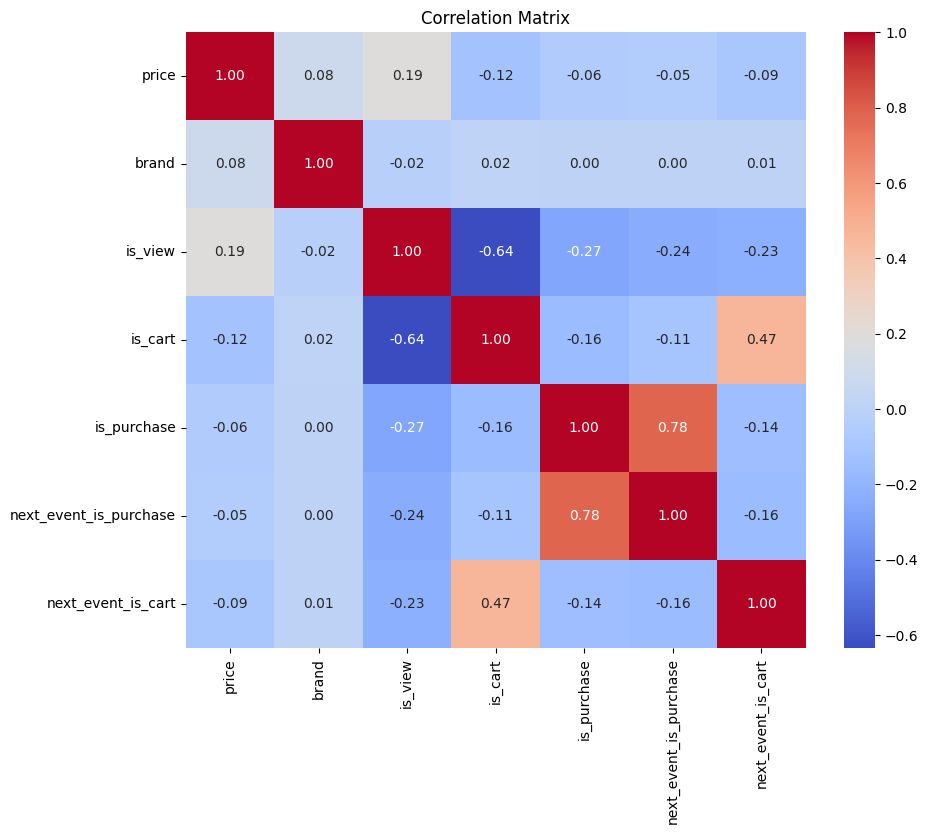

In [ ]:
# 브랜드를 숫자로 인코딩
df['brand'] = df['brand'].astype('category').cat.codes

# 상관관계 계산
correlation_matrix = df[['price', 'brand', 'is_view',
                          'is_cart', 'is_purchase',
                          'next_event_is_purchase',
                          'next_event_is_cart']].corr()

# 상관관계 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

- is_view is_cart 상관계수는 -0.64로 음의 상관관계를 가지고 있다고 해석할 수 있음
> page view가 올라갈수록 cart를 클릭할 확률이 낮아진다고 볼 수 있다. (하지만, 이것이 인과관계를 뜻하는 것은 아님)
- next_event_is_purchase와 is_purchase의 상관계수는 0.78로 강한 상관관계를 가지고 있다고 해석할 수 있음
> 소비자의 view - 다음 행동이 purchase라면, 구매확률이 높아질 수 있다고 해석할 수 있다. (하지만, 이것이 인과관계를 뜻하는 것은 아님)

2.2 인과관계 분석

2.2.1 로지스틱 회귀분석

In [ ]:
df['is_view'] = df['is_view'].astype(int)
df['is_cart'] = df['is_cart'].astype(int)


# 독립 변수와 종속 변수 설정
X = df[['is_view']]  # 독립 변수
y = df['is_cart']  # 종속 변수

# 상수항 추가
X = sm.add_constant(X)

# 회귀 모델 적합
model = sm.Logit(y, X)  # 로지스틱 회귀 모델 사용 (이진 분류 문제)
result = model.fit()

# 결과 요약 출력
print(result.summary())

         Current function value: 0.326071
         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                           Logit Regression Results                           
Dep. Variable:                is_cart   No. Observations:              1891487
Model:                          Logit   Df Residuals:                  1891485
Method:                           MLE   Df Model:                            1
Date:                Wed, 27 Nov 2024   Pseudo R-squ.:                  0.4391
Time:                        08:54:47   Log-Likelihood:            -6.1676e+05
converged:                      False   LL-Null:                   -1.0996e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2545      0.002    119.752      0.000       0.250       0.259
is_view      -12.2050      0.395    -30.875      0.000     -12.980     -11.430

Possibly complete quasi-separation: A fraction 0.52

- p-value의 값이 0.05보다 큼으로 통계적으로 유의미하다고 할 수 없음
> 두 변수가 명확한 인과관계를 가지고 있다고 보기 힘들다.

In [ ]:
df['is_purchase'] = df['is_cart'].astype(int)
df['next_event_is_purchase'] = df['next_event_is_purchase'].astype(int)


# 독립 변수와 종속 변수 설정
y = df[['is_purchase']]  # 독립 변수
X = df['next_event_is_purchase']  # 종속 변수

# 상수항 추가
X = sm.add_constant(X)

# 회귀 모델 적합
model = sm.Logit(y, X)  # 로지스틱 회귀 모델 사용 (이진 분류 문제)
result = model.fit()

# 결과 요약 출력
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.573972
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            is_purchase   No. Observations:              1891487
Model:                          Logit   Df Residuals:                  1891485
Method:                           MLE   Df Model:                            1
Date:                Wed, 27 Nov 2024   Pseudo R-squ.:                 0.01268
Time:                        08:54:57   Log-Likelihood:            -1.0857e+06
converged:                       True   LL-Null:                   -1.0996e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.9411      0.002   -562.779      0.000      -0.944      

 p-value의 값이 0.05보다 큼으로 통계적으로 유의미하다고 할 수 있음
> 하지만, 로지스틱회귀 모형에 대한 그래프가 s자를 그리지 않아 클래스의 불균형 문제가 의심

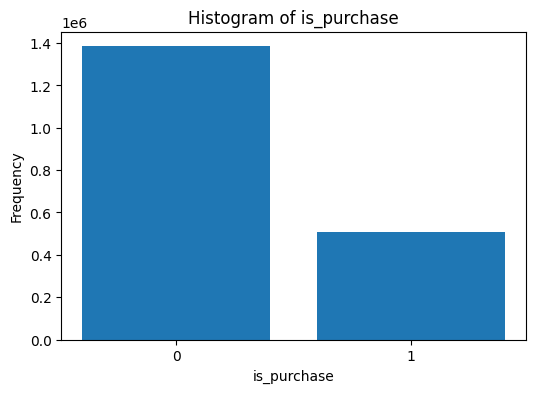

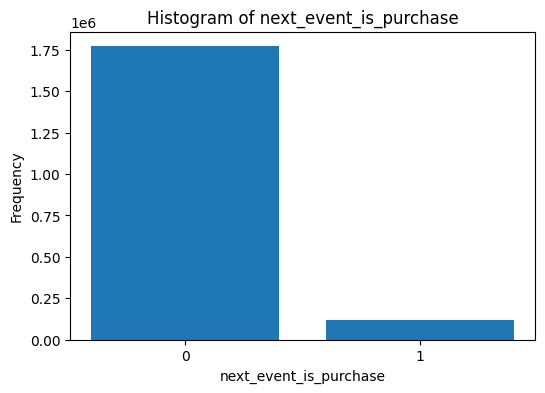

In [ ]:
# prompt: df['is_purchase'] = df['is_cart'].astype(int)
# df['next_event_is_purchase'] = df['next_event_is_purchase'].astype(int) 이변수들 클래스 불균형 확인하게 히스토그램 바 그려줘 (x축 0, 1 로만)

import matplotlib.pyplot as plt

# 'is_purchase' 변수의 히스토그램
plt.figure(figsize=(6, 4))
plt.hist(df['is_purchase'], bins=[-0.5, 0.5, 1.5], align='mid', rwidth=0.8)
plt.xticks([0, 1])
plt.xlabel('is_purchase')
plt.ylabel('Frequency')
plt.title('Histogram of is_purchase')
plt.show()

# 'next_event_is_purchase' 변수의 히스토그램
plt.figure(figsize=(6, 4))
plt.hist(df['next_event_is_purchase'], bins=[-0.5, 0.5, 1.5], align='mid', rwidth=0.8)
plt.xticks([0, 1])
plt.xlabel('next_event_is_purchase')
plt.ylabel('Frequency')
plt.title('Histogram of next_event_is_purchase')
plt.show()

- 종속변수와 독립변수의 클래스 불균형 차이가 크다는 것을 확인

클래스 불균형 문제 해결

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report

# 데이터 분할 (훈련 세트와 테스트 세트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest 모델 생성
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

# AdaBoost 모델 생성 (기본 분류기로 Decision Tree 사용)
ada_model = AdaBoostClassifier(n_estimators=50, random_state=42)

# Random Forest 모델 학습
rf_model.fit(X_train, y_train)

# AdaBoost 모델 학습 (기본 Decision Tree 사용)
ada_model.fit(X_train, y_train)

# 예측
y_pred_rf = rf_model.predict(X_test)
y_pred_ada = ada_model.predict(X_test)

# 성능 평가
print("Random Forest Classifier Report:")
print(classification_report(y_test, y_pred_rf))

print("AdaBoost Classifier Report:")
print(classification_report(y_test, y_pred_ada))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.



Random Forest Classifier Report:
              precision    recall  f1-score   support

           0       0.92      0.08      0.15    277043
           1       0.28      0.98      0.44    101255

    accuracy                           0.32    378298
   macro avg       0.60      0.53      0.29    378298
weighted avg       0.75      0.32      0.22    378298

AdaBoost Classifier Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           0       0.73      1.00      0.85    277043
           1       0.00      0.00      0.00    101255

    accuracy                           0.73    378298
   macro avg       0.37      0.50      0.42    378298
weighted avg       0.54      0.73      0.62    378298



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



- 트리기반 앙상블기법을 활용했지만, 1에 대한 예측이 매우 저조

In [ ]:
from xgboost import XGBClassifier

# 데이터 준비
X = df[['is_purchase']]  # 독립 변수
y = df['next_event_is_purchase']  # 종속 변수

# 데이터 분할 (훈련 세트와 테스트 세트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost 모델 생성
xgb_model = XGBClassifier(scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]), random_state=42)

# 모델 학습
xgb_model.fit(X_train, y_train)

# 예측
y_pred_xgb = xgb_model.predict(X_test)

# 성능 평가
print("XGBoost Classifier Report:")
print(classification_report(y_test, y_pred_xgb))

XGBoost Classifier Report:
              precision    recall  f1-score   support

           0       0.98      0.28      0.44    354294
           1       0.08      0.92      0.15     24004

    accuracy                           0.32    378298
   macro avg       0.53      0.60      0.29    378298
weighted avg       0.92      0.32      0.42    378298



- xgboost를 활용했지만, 1에 대한 예측이 매우 저조

In [ ]:
from imblearn.over_sampling import SMOTE

# 데이터 분할 (훈련 세트와 테스트 세트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SMOTE 적용
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# XGBoost 모델 생성 (class_weight는 필요 없음)
xgb_model = XGBClassifier(random_state=42)

# 모델 학습
xgb_model.fit(X_resampled, y_resampled)

# 예측
y_pred_xgb = xgb_model.predict(X_test)

# 성능 평가
print("XGBoost Classifier Report after SMOTE:")
print(classification_report(y_test, y_pred_xgb))

XGBoost Classifier Report after SMOTE:
              precision    recall  f1-score   support

           0       0.98      0.28      0.44    354294
           1       0.08      0.92      0.15     24004

    accuracy                           0.32    378298
   macro avg       0.53      0.60      0.29    378298
weighted avg       0.92      0.32      0.42    378298



- SMOTE를 활용하여 클래스 불균형 문제에 대한 해결하고 xgboost를 통해 모델링 했지만, 1에 대한 예측이 매우 저조

In [ ]:
from imblearn.over_sampling import RandomOverSampler

# 데이터 분할 (훈련 세트와 테스트 세트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 랜덤 오버샘플링 적용
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# XGBoost 모델 생성
xgb_model = XGBClassifier(random_state=42)

# 모델 학습
xgb_model.fit(X_resampled, y_resampled)

# 예측
y_pred_xgb = xgb_model.predict(X_test)

# 성능 평가
print("XGBoost Classifier Report after Random Over Sampling:")
print(classification_report(y_test, y_pred_xgb))

XGBoost Classifier Report after Random Over Sampling:
              precision    recall  f1-score   support

           0       0.98      0.28      0.44    354294
           1       0.08      0.92      0.15     24004

    accuracy                           0.32    378298
   macro avg       0.53      0.60      0.29    378298
weighted avg       0.92      0.32      0.42    378298



- Random Over Sampling을 통해 클래스 불균형 문제에 대한 해결하고 xgboost를 통해 모델링 했지만, 1에 대한 예측이 매우 저조

In [ ]:
# 데이터 분할 (훈련 세트와 테스트 세트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 랜덤 오버샘플링 적용 (선택 사항)
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# 클래스 가중치 계산
scale_pos_weight = len(y_resampled[y_resampled == 0]) / len(y_resampled[y_resampled == 1])

# XGBoost 모델 생성
xgb_model = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42)

# 모델 학습
xgb_model.fit(X_resampled, y_resampled)

# 예측
y_pred = xgb_model.predict(X_test)

# 성능 평가
print("XGBoost Classifier Report with Class Weights:")
print(classification_report(y_test, y_pred))

XGBoost Classifier Report with Class Weights:
              precision    recall  f1-score   support

           0       0.98      0.28      0.44    354294
           1       0.08      0.92      0.15     24004

    accuracy                           0.32    378298
   macro avg       0.53      0.60      0.29    378298
weighted avg       0.92      0.32      0.42    378298



- 가중치를 활용하여 클래스 불균형 문제에 대한 해결하고 xgboost를 통해 모델링 했지만, 1에 대한 예측이 매우 저조

> => next_event_is_purchase와 is_purchase 변수의 경우,
- P-value가 0.05 보다 낮아 인과관계가 유의미 하다고 판단할 수 있으나, 종속변수와 독립변수의 클래스 불균형 차이가 커 모델의 정확도가 현저히 낮음
- random sampling, smote, 앙상블 등 다양한 기법을 통해 클래스 불균형에 대한 문제를 해결하기 위해 노력했지만, 모델의 F-1 SCORE와 Accuracy값이 저조함
- 이에 따라 두 변수는 인과 관계가 있다고 할 수 있지만, 명확한 인과관계를 도출해내는데 한계가 있음

### **결론**

**퍼널 분석**

- View에서 Cart로 넘어오는 과정에서 많은 이탈이 발생함
- Cart에 담아두었던 제품 50%는 Cart에서 제거됨
- 고객들이 구매하는 제품의 평균 금액은 카트에서 제거되는 제품의 평균 금액보다 높음
- view - purchase의 여정을 가진 session 유저들은 Purchase로 전환될 확률이 매우 높음

**가설 검증**

1. '소비자들이 구매하는 브랜드/제품의 평균 가격은 카트에서 제거되는 브랜드/제품의 평균 가격 보다 높다' 에 대한 가설 검증

t-test를 통해 분석한 결과, 3가지 퍼널을 가진 session user들이 구매한 브랜드/제품의 평균 가격의 차이는 유의미함

- 고객들이 카트에 담는 물건값이 $23.88에 가까울수록, 카트에서 제거되지 않고 구매로 이어질 확률 높음

- 고객들이 카트에 담는 물건값이 $21.55에 가까울수록, 바로 구매로 이어질 수 있는 확률이 높음

- 고객들이 카트에 담는 물건값이 $7.88에 가까울수록, 카트에서 물건을 제거할 확률이 높음


2. 'view 다음 소비자의 다음 행동이 구매로 이어질 경우, 제품을 구매할 확률이 높다' 에 대한 가설 검증

next_event_is_purchase와 is_purchase변수를 토대로 상관관계 분석을 한 결과,
- 두 변수는 강한 상관관계를 가지고 있다는 것을 확인

next_event_is_purchase를 독립변수, is_purchase변수를 종속변수로 두고 인과관계 분석을 한 결과,
- 통계적으로 유의하다는 결과를 얻음

하지만, 클래스 불균형 문제로 모델의 정밀도, 정확도 등 성능이 현저히 낮다는 것을 알 수 있음

이에, 명확한 인과 관계를 도출해내는데 한계가 있다는 결론을 내림

**종합 인사이트**

- View에서 Cart로 넘어오는 전환율을 높이기 위해 가격대가 높고 사람들이 많이 구매하는 runai, jessenail, strong과 같은 제품들에 대한 구매를 유도하는 것이 중요
- 21 - 24달러 사이의 가격대에 제품을 추천하는 것이 구매로 이어질 수 있는 확률이 높음
> 프로모션, 온사이트 배너와 같은 영역에 적용 가능
- view page에서 바로 purchase로 넘어가는 유저들을 타겟 대상으로 삼고, 이들에 맞춘 영업/마케팅 전략을 구상하는 것이 필요
